In [152]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [153]:
data = pd.HDFStore('data/data.h5','r')
parammat=data['parammat']
targ=data['targ']
data.close()

In [154]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [155]:
fflds=targ.columns.get_level_values(0)
fdates=targ.columns.get_level_values(1)
flds=targ.columns.get_level_values(0).unique()
dates=targ.columns.get_level_values(1).unique()
nflds=targ.shape[1]
nflds

20

In [156]:
dnn_model=keras.models.load_model('data/dnn_cicero.keras')

/Users/sanderson/Documents/GitHub/ciceroscm/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [157]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [158]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [159]:
store = pd.HDFStore('data/obs.h5','r')
obs=store['obs']
obsunc=store['obsunc']
store.close()

In [160]:
np.where(targ.std()!=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),)

In [161]:
use=np.where(((np.isnan(obs)==False).to_numpy())&((targ.std()!=0).to_numpy()))

In [177]:
obsunc.loc['concentrations-CO2']=1
obsunc.loc['OHC700']=20



In [198]:
def skillscore(targ,obs,obsunc,use):
  errm=(((obs.to_numpy()-targ)/obsunc.to_numpy())**2)
  out=-np.sum((errm[:,use[0]]),axis=1)
  return out

In [207]:
skl=skillscore(YTraining.to_numpy(),obs,obsunc,use)

In [208]:
bst=np.where(skl>np.percentile(skl,99))


/var/folders/84/4wyjr_hn4z3_63hhr5k4mf6m0000gn/T/ipykernel_4820/2373216646.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i].axhline(obs[i],color='r')


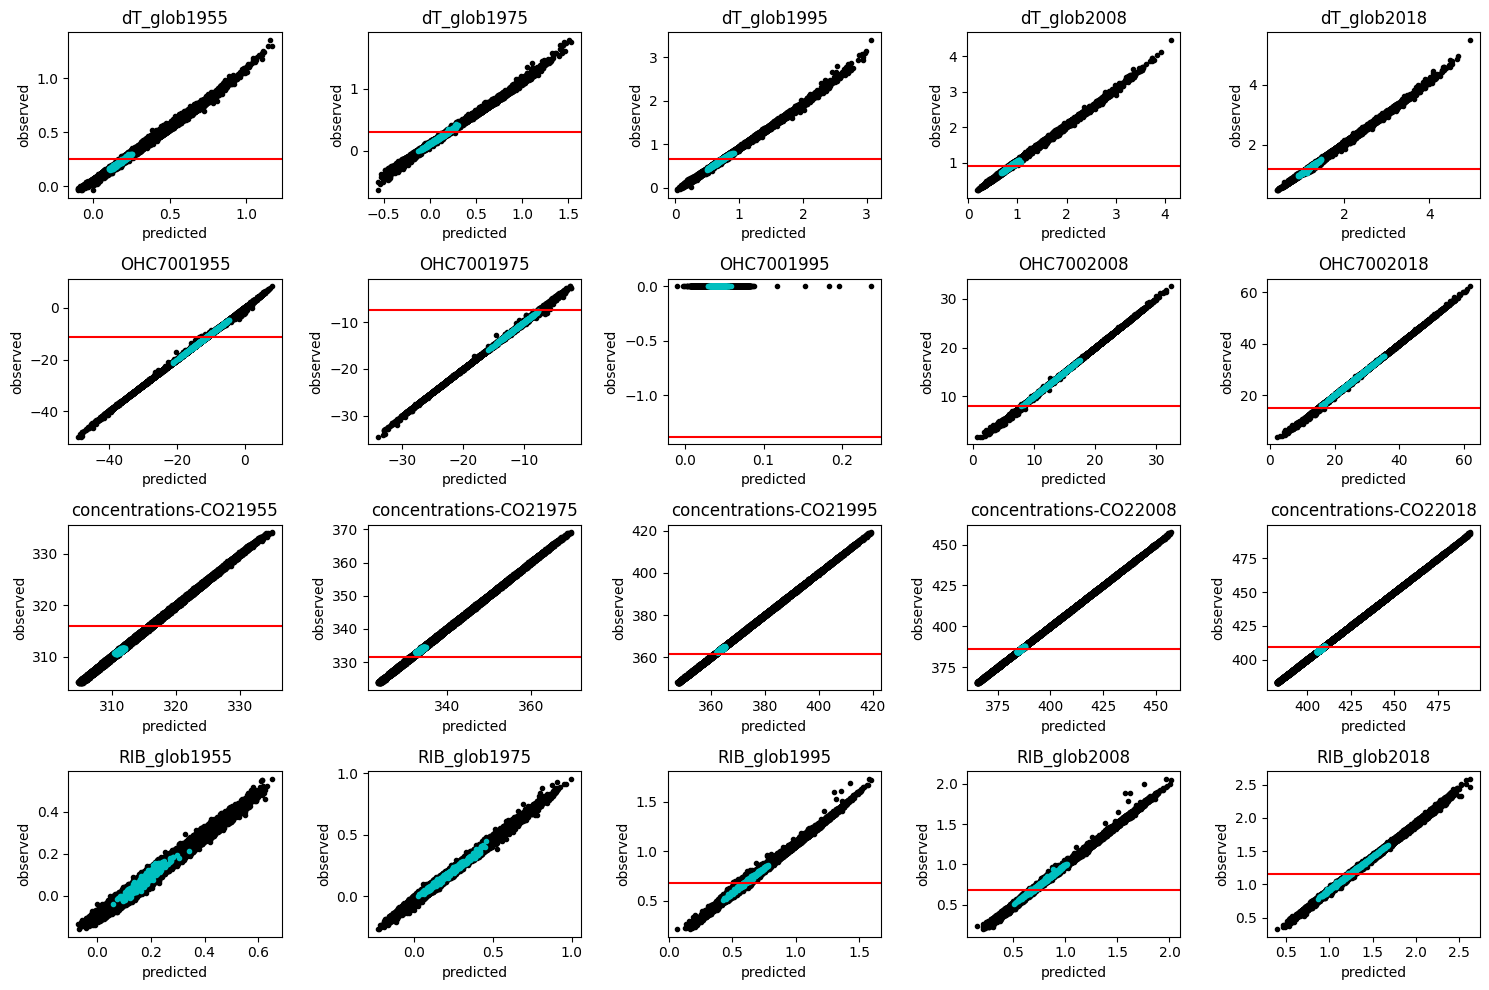

In [201]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'.k')
  ax[i].plot(pred_t[bst[0],i],Y_train.__array__()[bst[0],i],'.c')
  #ax[i].plot(pred[:,i],Y_dev[:,i],'r.')
  ax[i].set_title(fflds[i]+str(fdates[i]))
  ax[i].set_xlabel('predicted')
  ax[i].set_ylabel('observed')
  ax[i].axhline(obs[i],color='r')
plt.tight_layout()

In [216]:
def log_prob(p,obs,obsunc,use):
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    pred=dnn_model.predict(p,verbose = 0)
    out=skillscore(pred,obs,obsunc,use).T
    out[np.isnan(out)]=-5e5
    out[np.abs(out)>5e5]=-5e5

    return out

In [219]:
predskl=log_prob(XTraining,obs,obsunc,use)

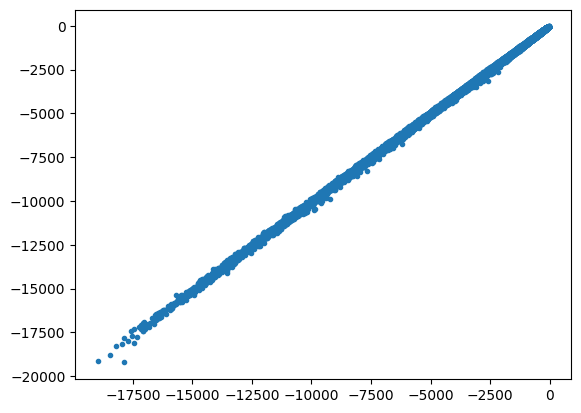

In [220]:
plt.plot(predskl,skl,'.')

In [222]:
import emcee


In [230]:
ndim=parammat.shape[1]
ndim

14

In [232]:
p0.shape

(450, 14)

In [233]:
ndim

14

In [237]:
bst[0]

array([    6,    44,   104,   172,   184,   318,   461,   471,   507,
         700,   858,   950,  1073,  1095,  1168,  1234,  1253,  1552,
        1596,  1661,  1723,  1766,  1888,  1990,  2046,  2089,  2091,
        2110,  2202,  2228,  2338,  2405,  2506,  2507,  2643,  2740,
        2882,  2900,  2978,  3038,  3284,  3480,  3522,  3769,  3955,
        4079,  4111,  4192,  4509,  4607,  4617,  4643,  4717,  4722,
        4820,  4910,  4928,  4930,  4938,  5129,  5151,  5162,  5198,
        5243,  5328,  5335,  5389,  5414,  5505,  5640,  5872,  5972,
        6019,  6155,  6434,  6551,  6589,  6741,  6782,  6798,  7022,
        7046,  7271,  7520,  7616,  7766,  7854,  8085,  8099,  8154,
        8189,  8327,  8410,  8443,  8486,  8523,  8695,  8760,  8791,
        8835,  8878,  8911,  9179,  9332,  9549,  9717, 10000, 10217,
       10281, 10417, 10428, 10446, 10487, 10610, 10677, 10954, 11011,
       11037, 11042, 11112, 11246, 11328, 11350, 11472, 11485, 11683,
       11789, 11823,

In [276]:


 nwalkers = len(bst[0])
ivar = 1. / np.random.rand(ndim)
p0 = X_train.__array__()[bst[0],:]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[obs,obsunc,use],vectorize=True)
sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████| 2000/2000 [06:23<00:00,  5.22it/s]


State([[ 1.5725875e+01  5.5742806e-01 -4.7095138e-01 ...  5.4253507e-01
   5.9913170e+01  1.3004434e-01]
 [-9.1109066e+00  7.1801031e-01 -7.1012712e-01 ...  2.5132290e-01
   1.0645938e+02  9.3219295e-02]
 [ 3.5836746e+01  3.6614814e-01  5.2952367e-01 ...  9.6072423e-01
  -5.6302772e+00  1.3857342e-01]
 ...
 [ 9.0703526e+00  6.4423102e-01  1.4694035e-01 ...  3.7425667e-01
   8.3768799e+01  7.9670474e-02]
 [ 2.7906193e+01 -1.1539582e-02  1.3945135e+00 ...  3.6540365e-01
   8.0787605e+01  7.1650431e-02]
 [ 1.9744503e+01  2.0140459e-01 -3.5129720e-01 ...  6.3351601e-01
   4.4760113e+01  1.5931255e-01]], log_prob=[-37.41001492 -41.28808932 -38.76630511 -35.55117337 -37.20103492
 -42.60022369 -36.2637918  -45.44112806 -38.85276633 -41.11161511
 -37.88605254 -38.19659302 -33.28960626 -36.56824591 -41.13040413
 -34.83188071 -35.73745457 -38.49548151 -35.20091307 -35.6650359
 -37.89925661 -37.24508616 -35.885494   -35.95009564 -37.61143464
 -39.37174295 -39.3098124  -34.69678986 -37.28723749 -3

(array([   3.,   13.,   23.,  115.,  235.,  572., 1148., 1599.,  697.,
          95.]),
 array([-47.67222545, -46.17988864, -44.68755182, -43.195215  ,
        -41.70287818, -40.21054136, -38.71820454, -37.22586772,
        -35.73353091, -34.24119409, -32.74885727]),
 <BarContainer object of 10 artists>)

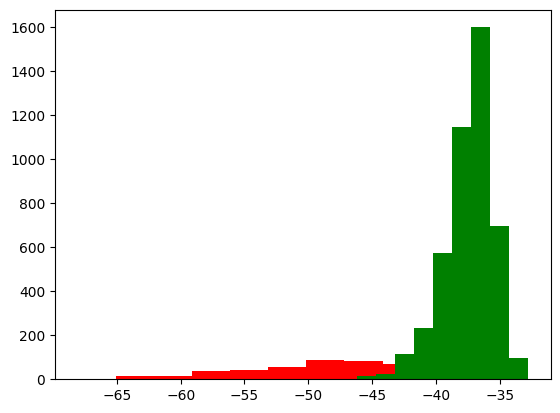

In [277]:
plt.hist(log_prob(p0,obs,obsunc,use),color='r')
plt.hist(log_prob(np.vstack(sampler.chain[:,-10:,:]),obs,obsunc,use),color='g')